In [2]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [4]:
# load query file where we added volumes for each area
# volumes = pd.read_csv("query_complete_with_volumes.csv")
# volumes = ace.clean_volumes_database(volumes)

In [5]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [6]:
volumes

,id,atlas_id,name,st_level,parent_structure_id,depth,structure_id_path,safe_name,mean_volume,0,1,2,3,4,5,6,7,8,9,10
0,997,-1.0,root,0,NaN,0,/997/,root,435.287861,997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,0.0,Basic cell groups and regions,1,997.0,1,/997/8/,Basic cell groups and regions,197.462441,997,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,567,70.0,Cerebrum,2,8.0,2,/997/8/567/,Cerebrum,120.883542,997,8.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,688,85.0,Cerebral cortex,3,567.0,3,/997/8/567/688/,Cerebral cortex,97.403809,997,8.0,567.0,688.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,695,86.0,Cortical plate,4,688.0,4,/997/8/567/688/695/,Cortical plate,93.461964,997,8.0,567.0,688.0,695.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,49,713.0,intraparafloccular fissure,8,1040.0,3,/997/1024/1040/49/,intraparafloccular fissure,NaN,997,1024.0,1040.0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1323,57,714.0,paramedian sulcus,8,1040.0,3,/997/1024/1040/57/,paramedian sulcus,NaN,997,1024.0,1040.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1324,65,715.0,parafloccular sulcus,8,1040.0,3,/997/1024/1040/65/,parafloccular sulcus,NaN,997,1024.0,1040.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325,624,926.0,Interpeduncular fossa,7,1024.0,2,/997/1024/624/,Interpeduncular fossa,NaN,997,1024.0,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on C57 : threshold 300

In [8]:
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}

In [9]:
dict_results_across_mice = np.load('dict_results_across_mice_c57.npy', allow_pickle=True).item()

# List areas with null cell count

In [10]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

<AxesSubplot:>

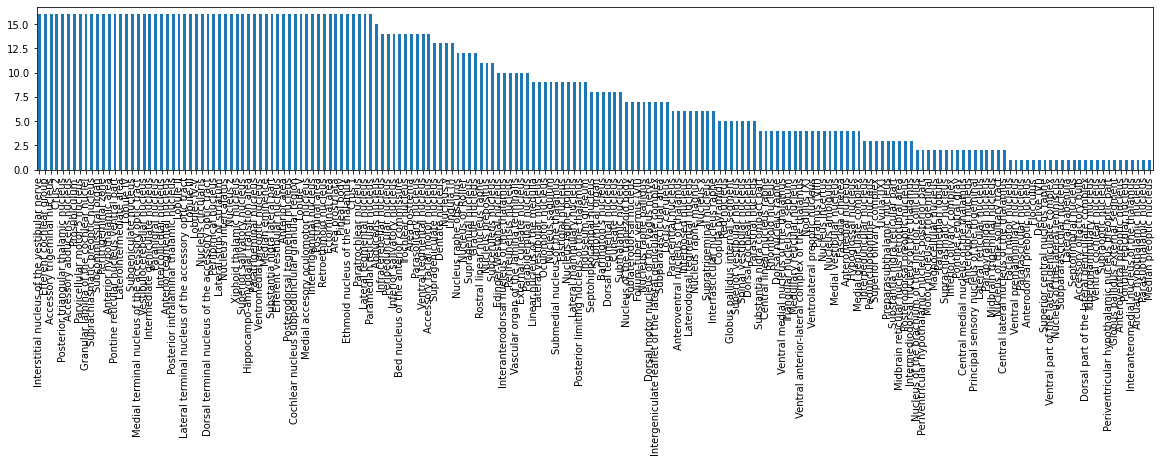

In [11]:
# make histogram of these
null_areas = [db_null_count[subjects[0]].area.values]
for subject in subjects[1:]:
    null_areas.append(db_null_count[subject].area.values)
null_areas = np.hstack(null_areas)
fig, ax = plt.subplots(1,1,figsize=(20,3))
pd.Series(null_areas).value_counts(sort=True).plot(kind='bar', axes=ax)


In [12]:
# print areas that are null for all mice
df = pd.DataFrame(pd.Series(null_areas).value_counts(sort=False))
df.columns = ['counts']
df = df[df.counts == 16]
print(df.to_string(), len(df))

                                                       counts
Superior salivatory nucleus                                16
Anterior area                                              16
Postrhinal area                                            16
Subgeniculate nucleus                                      16
Lateral strip of striatum                                  16
Subcommissural organ                                       16
Medial terminal nucleus of the accessory optic tract       16
Intercollicular nucleus                                    16
Lobule II                                                  16
Interstitial nucleus of the vestibular nerve               16
Nucleus circularis                                         16
Accessory trigeminal nucleus                               16
Lobule IV                                                  16
Parvicellular motor 5 nucleus                              16
Accessory abducens nucleus                                 16
Lateral 

# List areas with no volume

In [13]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

<AxesSubplot:>

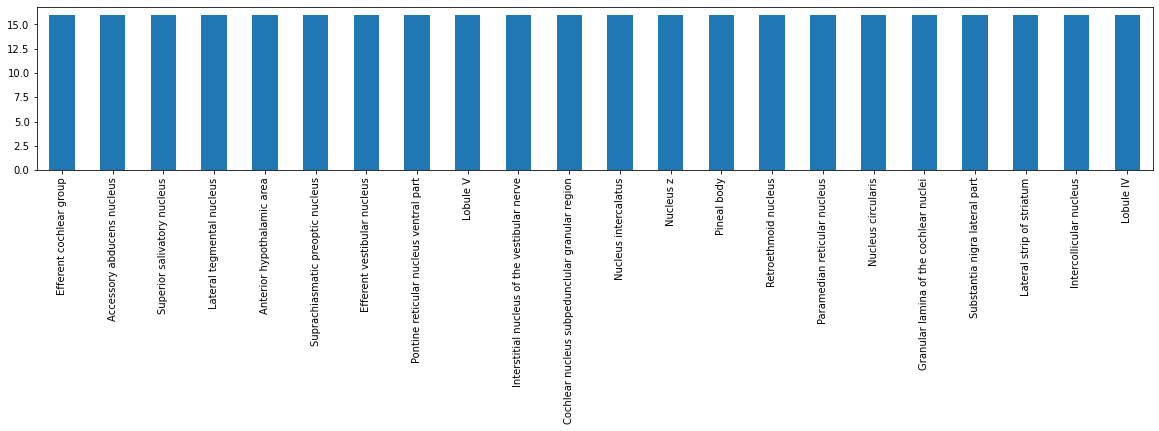

In [14]:
# make histogram of these
null_volume = [db_null_volume[subjects[0]].area.values]
for subject in subjects[1:]:
    null_volume.append(db_null_volume[subject].area.values)
null_volume = np.hstack(null_volume)
fig, ax = plt.subplots(1,1,figsize=(20,3))
pd.Series(null_volume).value_counts(sort=True).plot(kind='bar', axes=ax)

In [15]:
# print areas that are null for all mice
df = pd.DataFrame(pd.Series(null_volume).value_counts(sort=False))
df.columns = ['counts']
df = df[df.counts == 16]
print(df.to_string())

                                                 counts
Lobule IV                                            16
Superior salivatory nucleus                          16
Lateral tegmental nucleus                            16
Anterior hypothalamic area                           16
Suprachiasmatic preoptic nucleus                     16
Efferent vestibular nucleus                          16
Pontine reticular nucleus ventral part               16
Lobule V                                             16
Interstitial nucleus of the vestibular nerve         16
Cochlear nucleus subpedunclular granular region      16
Nucleus intercalatus                                 16
Nucleus z                                            16
Pineal body                                          16
Retroethmoid nucleus                                 16
Paramedian reticular nucleus                         16
Nucleus circularis                                   16
Granular lamina of the cochlear nuclei          

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [16]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['F10Control', 'F16Control', 'F11Control', 'F1Control'],
 'Unfam': ['F6Unfam', 'F8Unfam', 'F4Unfam', 'F2Unfam', 'F12Unfam', 'F14Unfam'],
 'Fam': ['F7Fam', 'F15Fam', 'F13Fam', 'F5Fam', 'F3Fam', 'F9Fam']}

# Calculate cell count across experimental groups

In [18]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [19]:
df_control_cell_count

,area,F10Control,F16Control,F11Control,F1Control
0,Frontal pole cerebral cortex,59,23,106,105
1,Primary motor area,1447,41,155,259
2,Secondary motor area,2448,219,587,1448
3,Primary somatosensory area,2755,444,377,1442
4,Supplemental somatosensory area,1055,122,403,493
...,...,...,...,...,...
293,Flocculus,19,1,1,28
294,Fastigial nucleus,1,0,1,0
295,Interposed nucleus,5,0,0,1
296,Dentate nucleus,0,0,0,1


In [20]:
df_fam_cell_count

,area,F7Fam,F15Fam,F13Fam,F5Fam,F3Fam,F9Fam
0,Frontal pole cerebral cortex,81,64,20,131,48,133
1,Primary motor area,189,304,413,178,387,471
2,Secondary motor area,1052,630,728,1198,405,1287
3,Primary somatosensory area,988,492,947,918,748,1548
4,Supplemental somatosensory area,434,774,649,404,391,433
...,...,...,...,...,...,...,...
293,Flocculus,4,2,4,2,0,42
294,Fastigial nucleus,3,1,0,1,0,0
295,Interposed nucleus,2,4,0,5,1,1
296,Dentate nucleus,0,0,0,0,0,0


In [21]:
df_unfam_cell_count

,area,F6Unfam,F8Unfam,F4Unfam,F2Unfam,F12Unfam,F14Unfam
0,Frontal pole cerebral cortex,566,267,110,284,147,31
1,Primary motor area,4115,533,314,565,105,227
2,Secondary motor area,8207,1616,516,1696,633,343
3,Primary somatosensory area,7257,1974,609,1971,594,602
4,Supplemental somatosensory area,6662,595,335,409,303,289
...,...,...,...,...,...,...,...
293,Flocculus,14,39,1,167,5,3
294,Fastigial nucleus,20,0,0,0,13,0
295,Interposed nucleus,12,4,0,0,9,0
296,Dentate nucleus,1,0,0,0,8,0


## Calculate t-tests across groups per area

In [22]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.829216,0.137702,0.0794234
1,Primary motor area,0.583415,0.563277,0.327241
2,Secondary motor area,0.51672,0.548981,0.323879
3,Primary somatosensory area,0.526337,0.529319,0.275283
4,Supplemental somatosensory area,0.98191,0.507623,0.402029
...,...,...,...,...
293,Flocculus,0.750036,0.460393,0.309023
294,Fastigial nucleus,0.615903,0.298622,0.227029
295,Interposed nucleus,0.638646,0.373719,0.400549
296,Dentate nucleus,0.241504,0.470338,0.278933


In [23]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_ttest_not_null_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.829216,0.137702,0.0794234
1,Primary motor area,0.583415,0.563277,0.327241
2,Secondary motor area,0.51672,0.548981,0.323879
3,Primary somatosensory area,0.526337,0.529319,0.275283
4,Supplemental somatosensory area,0.98191,0.507623,0.402029
...,...,...,...,...
292,Paraflocculus,0.19887,0.417043,0.69199
293,Flocculus,0.750036,0.460393,0.309023
294,Fastigial nucleus,0.615903,0.298622,0.227029
295,Interposed nucleus,0.638646,0.373719,0.400549


In [24]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,6.17713e-05
Bed nuclei of the stria terminalis,0.001609
Ventral premammillary nucleus,0.00264979
Medial amygdalar nucleus,0.00310501
Cortical amygdalar area,0.00381713
Medial preoptic nucleus,0.00724906
Tuberal nucleus,0.0119723
Bed nucleus of the accessory olfactory tract,0.0133743
Accessory olfactory bulb,0.0196169


In [25]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.000247517
Ventral premammillary nucleus,0.000490979
Cortical amygdalar area,0.00153788
Bed nuclei of the stria terminalis,0.00212997
Medial amygdalar nucleus,0.00213564
Periventricular hypothalamic nucleus posterior part,0.00271455
Nucleus of reuniens,0.00862385
Posterodorsal preoptic nucleus,0.012407
Tuberal nucleus,0.0132163


In [26]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Supramammillary nucleus,0.0111725
Nucleus of reuniens,0.0141052
Interanteromedial nucleus of the thalamus,0.0147649
Rhomboid nucleus,0.0224609
Nucleus incertus,0.0344045
Preparasubthalamic nucleus,0.0408905
Central medial nucleus of the thalamus,0.0459932
Tuberomammillary nucleus,0.0484734
Intermediodorsal nucleus of the thalamus,0.0509426


## Mann Whitney Test for comparison across groups

In [27]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0463479
1,Primary motor area,0.227773,0.227773,0.235585
2,Secondary motor area,0.457553,0.37456,0.34446
3,Primary somatosensory area,0.457553,0.227773,0.34446
4,Supplemental somatosensory area,0.457553,0.457553,0.189239
...,...,...,...,...
293,Flocculus,0.457163,0.294743,0.148129
294,Fastigial nucleus,0.453093,0.452019,0.464352
295,Interposed nucleus,0.255335,0.366498,0.467403
296,Dentate nucleus,0.153717,0.396074,0.0878672


In [28]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_not_null_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0463479
1,Primary motor area,0.227773,0.227773,0.235585
2,Secondary motor area,0.457553,0.37456,0.34446
3,Primary somatosensory area,0.457553,0.227773,0.34446
4,Supplemental somatosensory area,0.457553,0.457553,0.189239
...,...,...,...,...
292,Paraflocculus,0.120477,0.260583,0.189239
293,Flocculus,0.457163,0.294743,0.148129
294,Fastigial nucleus,0.453093,0.452019,0.464352
295,Interposed nucleus,0.255335,0.366498,0.467403


In [29]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.00696096
Bed nucleus of the accessory olfactory tract,0.00696096
Medial preoptic nucleus,0.00710702
Tuberal nucleus,0.00710702
Medial amygdalar nucleus,0.00710702
Posterior amygdalar nucleus,0.00710702
Cortical amygdalar area,0.00710702
Bed nuclei of the stria terminalis,0.00710702
Periventricular hypothalamic nucleus posterior part,0.0123705


In [30]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Nucleus incertus,0.00639034
Central linear nucleus raphe,0.00653092
Periventricular hypothalamic nucleus posterior part,0.00696096
Ventral premammillary nucleus,0.00696096
Posterior amygdalar nucleus,0.00710702
Medial amygdalar nucleus,0.00710702
Bed nuclei of the stria terminalis,0.00710702
Piriform-amygdalar area,0.00710702
Tuberal nucleus,0.00710702


In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Supramammillary nucleus,0.00253743
Intermediodorsal nucleus of the thalamus,0.0122348
Preparasubthalamic nucleus,0.012807
Interanteromedial nucleus of the thalamus,0.01474
Nucleus incertus,0.015174
Nucleus of reuniens,0.0153195
Rhomboid nucleus,0.0219132
Tuberomammillary nucleus,0.0224756
Interpeduncular nucleus,0.0262776


## Calculate cross corr across groups per area on cell count

In [33]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_control_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,-0.119463,0.161993,-0.025738,0.163608,0.631976,0.588897,0.610254,0.570534,0.471496,...,0.081575,-0.570685,-0.244981,-0.106474,0.468740,0.367081,0.370496,0.266781,-0.138152,0.528685
Primary motor area,-0.119463,1.000000,0.915245,0.939714,0.959388,0.393943,0.669511,0.408920,0.312560,0.652974,...,0.875916,-0.745782,0.977373,0.990048,0.794893,0.523567,0.439681,0.574915,0.994054,-0.220775
Secondary motor area,0.161993,0.915245,1.000000,0.981777,0.964243,0.729246,0.889500,0.741055,0.668393,0.901943,...,0.984530,-0.850298,0.908835,0.867870,0.819338,0.814719,0.752924,0.397921,0.936175,0.183053
Primary somatosensory area,-0.025738,0.939714,0.981777,1.000000,0.936678,0.632840,0.791312,0.649173,0.587224,0.832801,...,0.986443,-0.743225,0.962591,0.885028,0.725694,0.772396,0.711752,0.323290,0.967845,0.112350
Supplemental somatosensory area,0.163608,0.959388,0.964243,0.936678,1.000000,0.589483,0.841240,0.598618,0.494953,0.798291,...,0.907295,-0.900196,0.906914,0.948630,0.914784,0.647329,0.566822,0.622121,0.951677,-0.043034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.367081,0.523567,0.814719,0.772396,0.647329,0.952861,0.871672,0.960912,0.961593,0.960815,...,0.865996,-0.643609,0.578781,0.420583,0.504824,1.000000,0.994849,-0.099685,0.590615,0.715305
Flocculus,0.370496,0.439681,0.752924,0.711752,0.566822,0.950109,0.828780,0.957726,0.972514,0.931697,...,0.816497,-0.573964,0.507159,0.329494,0.422222,0.994849,1.000000,-0.192450,0.513436,0.777778
Fastigial nucleus,0.266781,0.574915,0.397921,0.323290,0.622121,0.000000,0.379407,-0.007207,-0.154631,0.177139,...,0.235702,-0.688247,0.393435,0.677708,0.808290,-0.099685,-0.192450,1.000000,0.485071,-0.577350


In [34]:
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_fam_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Pyramus (VIII),Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,-0.248352,0.838450,0.555886,-0.508390,-0.402518,-0.047034,-0.671118,0.538818,-0.897261,...,-0.914483,-0.599577,0.366524,0.323303,0.610115,0.168426,0.795513,0.566719,0.152736,0.500896
Primary motor area,-0.248352,1.000000,-0.228502,0.394937,0.145731,-0.052919,0.307654,0.563190,0.483570,0.146179,...,0.302698,0.454177,-0.096015,0.340706,0.453622,-0.837258,-0.062340,0.576926,-0.803685,-0.736076
Secondary motor area,0.838450,-0.228502,1.000000,0.740562,-0.393241,-0.444366,0.459866,-0.655790,0.640759,-0.825277,...,-0.682503,-0.179022,0.481894,0.541123,0.704801,0.383236,0.874984,0.605368,0.278447,0.243209
Primary somatosensory area,0.555886,0.394937,0.740562,1.000000,-0.514257,-0.574197,0.662506,-0.042868,0.889501,-0.618619,...,-0.504111,0.078269,0.261551,0.730216,0.944904,-0.054581,0.837546,0.874837,-0.160074,-0.410713
Supplemental somatosensory area,-0.508390,0.145731,-0.393241,-0.514257,1.000000,0.763181,0.052683,-0.172367,-0.444399,0.351762,...,0.782978,0.458128,0.303461,-0.060513,-0.366822,-0.226681,-0.587393,-0.224326,-0.097885,0.080383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Copula pyramidis,0.168426,-0.837258,0.383236,-0.054581,-0.226681,0.038594,0.194055,-0.423276,-0.339282,-0.246864,...,-0.237535,-0.254704,0.313940,0.101827,-0.145913,1.000000,0.337244,-0.335001,0.947733,0.318799
Paraflocculus,0.795513,-0.062340,0.874984,0.837546,-0.587393,-0.371854,0.449459,-0.408229,0.598034,-0.898712,...,-0.769250,-0.376538,0.534226,0.744363,0.852227,0.337244,1.000000,0.737312,0.312285,-0.007524
Flocculus,0.566719,0.576926,0.605368,0.874837,-0.224326,-0.237893,0.494678,-0.152027,0.789570,-0.702705,...,-0.421778,-0.033720,0.472661,0.803105,0.974360,-0.335001,0.737312,1.000000,-0.305579,-0.311010


In [35]:
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)
corr_matrix_unfam_ncells

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.902023,0.939890,0.953106,0.877935,0.893917,0.887154,0.881074,0.881239,0.822717,...,-0.114950,0.854642,0.841372,0.654887,0.439620,0.896532,0.214446,0.662725,0.674569,-0.120730
Primary motor area,0.902023,1.000000,0.994477,0.986813,0.996400,0.999076,0.990990,0.991142,0.975044,0.975503,...,0.197629,0.990035,0.975005,0.726039,0.425545,0.939894,-0.098631,0.755104,0.692770,-0.154358
Secondary motor area,0.939890,0.994477,1.000000,0.996765,0.987470,0.993022,0.984972,0.981355,0.966633,0.955183,...,0.144974,0.978585,0.967542,0.742821,0.445769,0.947376,-0.031534,0.759926,0.715885,-0.129144
Primary somatosensory area,0.953106,0.986813,0.996765,1.000000,0.974260,0.983349,0.975146,0.965209,0.947304,0.932761,...,0.142512,0.962361,0.952492,0.712496,0.480012,0.952569,0.019998,0.715537,0.683032,-0.181049
Supplemental somatosensory area,0.877935,0.996400,0.987470,0.974260,1.000000,0.998825,0.994447,0.994311,0.975989,0.985866,...,0.226309,0.998113,0.986601,0.763910,0.426670,0.937037,-0.169440,0.796550,0.734153,-0.092424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.896532,0.939894,0.947376,0.952569,0.937037,0.941196,0.966821,0.926726,0.884408,0.910378,...,0.214432,0.928025,0.925026,0.684006,0.686794,1.000000,-0.178729,0.680027,0.720119,-0.178414
Flocculus,0.214446,-0.098631,-0.031534,0.019998,-0.169440,-0.127159,-0.199478,-0.174977,-0.124831,-0.280580,...,-0.453602,-0.207665,-0.215147,-0.238829,-0.272918,-0.178729,1.000000,-0.321341,-0.346020,-0.279038
Fastigial nucleus,0.662725,0.755104,0.759926,0.715537,0.796550,0.776991,0.778854,0.797425,0.799212,0.801594,...,0.088373,0.817514,0.835587,0.952202,0.197539,0.680027,-0.321341,1.000000,0.953241,0.527372


## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

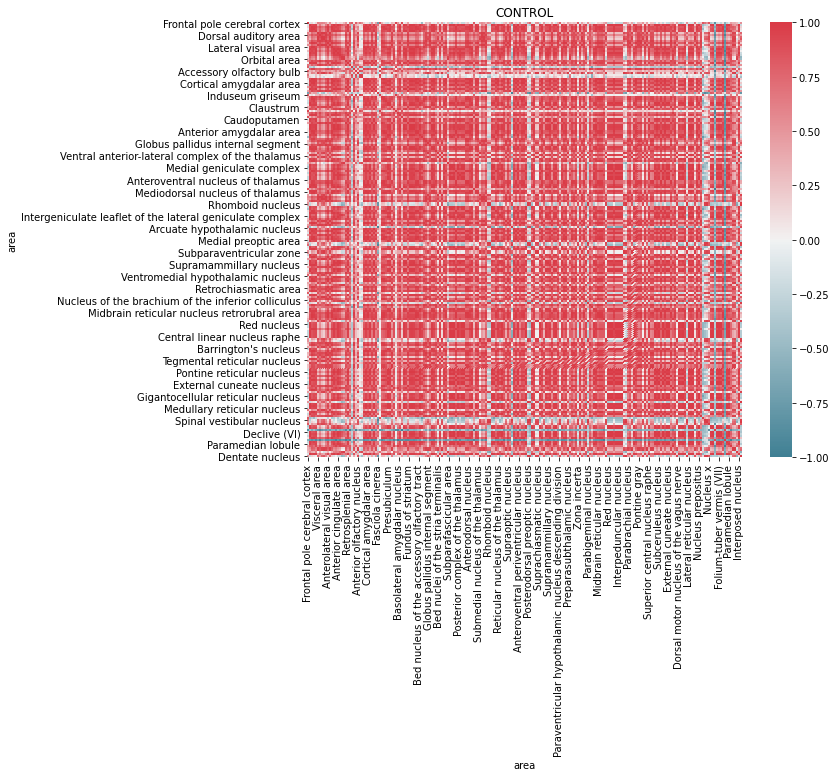

In [36]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

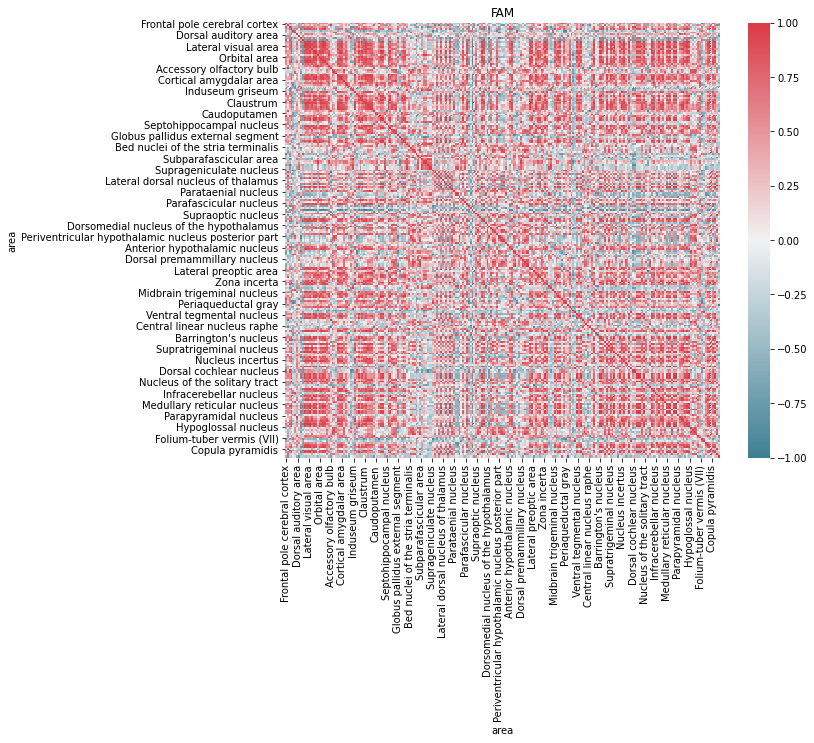

In [37]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

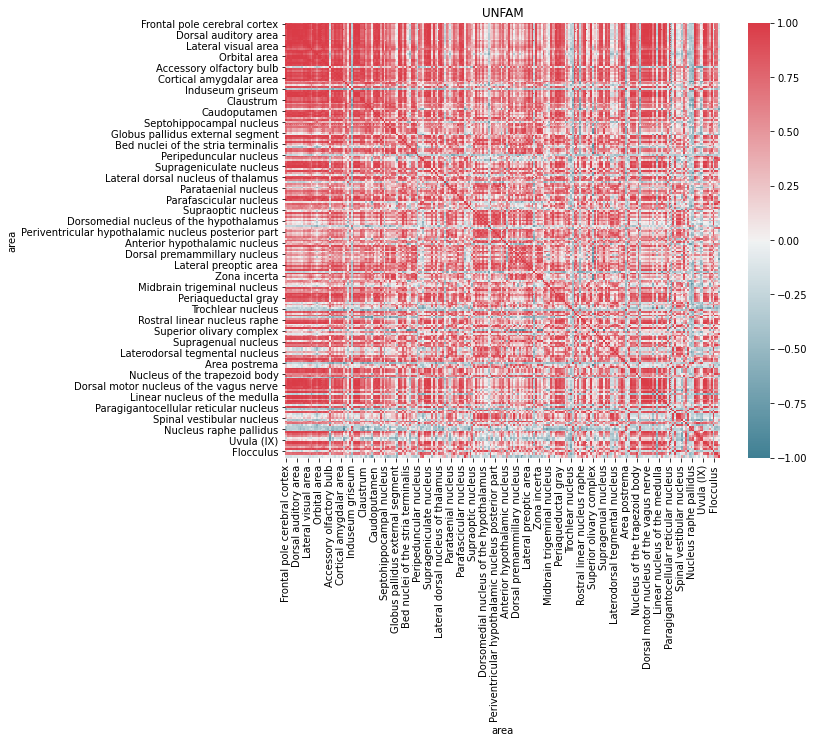

In [38]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [44]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [45]:
df_control_energy

,area,F10Control,F16Control,F11Control,F1Control
0,Frontal pole cerebral cortex,162101.616469,45852.503979,215700.991098,231505.087775
1,Primary motor area,364550.613676,8473.118078,32714.603757,56989.229935
2,Secondary motor area,514921.732492,38530.662549,105483.767790,269030.646286
3,Primary somatosensory area,334889.672220,53371.646658,38472.056519,167252.194756
4,Supplemental somatosensory area,324970.319497,34786.891993,107677.725014,135606.963231
...,...,...,...,...,...
293,Flocculus,52430.273979,1266.952636,2013.309043,43000.574639
294,Fastigial nucleus,4434.056758,0.000000,3255.655641,0.000000
295,Interposed nucleus,13223.707791,0.000000,0.000000,3586.765722
296,Dentate nucleus,0.000000,0.000000,0.000000,5824.567344


In [46]:
df_fam_energy

,area,F7Fam,F15Fam,F13Fam,F5Fam,F3Fam,F9Fam
0,Frontal pole cerebral cortex,202495.870411,145792.942019,43910.280011,268573.533459,101187.866423,334042.499512
1,Primary motor area,54638.029917,71690.394574,110299.469993,44672.405812,94238.953115,109713.396056
2,Secondary motor area,212137.335194,115916.836242,145483.056195,213175.989036,77292.596618,241137.956689
3,Primary somatosensory area,137141.781500,57956.380154,120009.400562,123727.854930,80661.820371,172376.753588
4,Supplemental somatosensory area,154571.389229,216075.852583,193026.015826,112436.594169,115353.222198,120744.695640
...,...,...,...,...,...,...,...
293,Flocculus,7461.879288,4338.301912,8189.703143,5231.233956,0.000000,91798.468454
294,Fastigial nucleus,10584.106384,4016.885560,0.000000,5999.523936,0.000000,0.000000
295,Interposed nucleus,6321.674585,11099.047263,0.000000,13667.071887,2714.982387,2964.063340
296,Dentate nucleus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
df_unfam_energy

,area,F6Unfam,F8Unfam,F4Unfam,F2Unfam,F12Unfam,F14Unfam
0,Frontal pole cerebral cortex,1.548755e+06,716936.937542,257979.402518,639418.173719,318999.274080,79963.563271
1,Primary motor area,9.805630e+05,148053.796718,67677.435268,124139.376198,24905.281976,67581.170010
2,Secondary motor area,1.697297e+06,364390.856541,92494.821600,301644.239041,115271.792053,75266.127309
3,Primary somatosensory area,7.869631e+05,277310.730919,61122.029473,223057.304181,62153.776599,98217.209227
4,Supplemental somatosensory area,2.130749e+06,216322.753494,85946.638549,113231.853630,84543.642519,107577.492886
...,...,...,...,...,...,...,...
293,Flocculus,2.395417e+04,90093.473683,1400.050054,295085.399320,7429.868517,7254.651663
294,Fastigial nucleus,9.445272e+04,0.000000,0.000000,0.000000,48254.235527,0.000000
295,Interposed nucleus,3.082875e+04,12185.040217,0.000000,0.000000,20160.612330,0.000000
296,Dentate nucleus,6.487046e+03,0.000000,0.000000,0.000000,46878.584243,0.000000


## T-test on energy across groups

In [50]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.77621,0.150396,0.0900627
1,Primary motor area,0.620508,0.563644,0.328591
2,Secondary motor area,0.494335,0.544893,0.312683
3,Primary somatosensory area,0.582874,0.515577,0.261163
4,Supplemental somatosensory area,0.981684,0.489713,0.38625
...,...,...,...,...
293,Flocculus,0.811726,0.459682,0.319257
294,Fastigial nucleus,0.543499,0.311725,0.239678
295,Interposed nucleus,0.613613,0.396423,0.459285
296,Dentate nucleus,0.241504,0.46329,0.273164


In [51]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_ttest_not_null_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.77621,0.150396,0.0900627
1,Primary motor area,0.620508,0.563644,0.328591
2,Secondary motor area,0.494335,0.544893,0.312683
3,Primary somatosensory area,0.582874,0.515577,0.261163
4,Supplemental somatosensory area,0.981684,0.489713,0.38625
...,...,...,...,...
292,Paraflocculus,0.187027,0.398139,0.796329
293,Flocculus,0.811726,0.459682,0.319257
294,Fastigial nucleus,0.543499,0.311725,0.239678
295,Interposed nucleus,0.613613,0.396423,0.459285


In [52]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000567236
Bed nuclei of the stria terminalis,0.0031939
Cortical amygdalar area,0.00564351
Medial amygdalar nucleus,0.00584023
Medial preoptic nucleus,0.00775818
Ventral premammillary nucleus,0.00794633
Bed nucleus of the accessory olfactory tract,0.011894
Tuberal nucleus,0.0158849
Accessory olfactory bulb,0.0208514


In [53]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.00204643
Cortical amygdalar area,0.00329962
Periventricular hypothalamic nucleus posterior part,0.00533715
Nucleus of reuniens,0.00541071
Ventral premammillary nucleus,0.0072792
Bed nuclei of the stria terminalis,0.00731332
Medial amygdalar nucleus,0.00943985
Posterodorsal preoptic nucleus,0.0110938
Nucleus incertus,0.018293


In [54]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Nucleus of reuniens,0.00638682
Interanteromedial nucleus of the thalamus,0.0149844
Rhomboid nucleus,0.0156869
Supramammillary nucleus,0.0192732
Nucleus incertus,0.0267835
Central medial nucleus of the thalamus,0.0410569
Suprachiasmatic nucleus,0.0479815
Medial mammillary nucleus,0.0482458
Intermediodorsal nucleus of the thalamus,0.0576893


## Mann-Whitney Test across groups

In [55]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0641026
1,Primary motor area,0.227773,0.168678,0.287587
2,Secondary motor area,0.457553,0.37456,0.405091
3,Primary somatosensory area,0.457553,0.227773,0.287587
4,Supplemental somatosensory area,0.297016,0.457553,0.235585
...,...,...,...,...
293,Flocculus,0.457553,0.297016,0.235585
294,Fastigial nucleus,0.366498,0.452204,0.464429
295,Interposed nucleus,0.294743,0.366498,0.5
296,Dentate nucleus,0.153717,0.346987,0.0878672


In [56]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_not_null_energy

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.457553,0.0349772,0.0641026
1,Primary motor area,0.227773,0.168678,0.287587
2,Secondary motor area,0.457553,0.37456,0.405091
3,Primary somatosensory area,0.457553,0.227773,0.287587
4,Supplemental somatosensory area,0.297016,0.457553,0.235585
...,...,...,...,...
292,Paraflocculus,0.120477,0.297016,0.189239
293,Flocculus,0.457553,0.297016,0.235585
294,Fastigial nucleus,0.366498,0.452204,0.464429
295,Interposed nucleus,0.294743,0.366498,0.5


In [57]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Pineal body,0.00710702
Efferent vestibular nucleus,0.00710702
Accessory abducens nucleus,0.00710702
Nucleus z,0.00710702
Bed nuclei of the stria terminalis,0.00710702
Intercollicular nucleus,0.00710702
Substantia nigra lateral part,0.00710702
Cortical amygdalar area,0.00710702
Medial amygdalar nucleus,0.00710702


In [58]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Central linear nucleus raphe,0.00653092
Nucleus incertus,0.00653092
Periventricular hypothalamic nucleus posterior part,0.00696096
Retroethmoid nucleus,0.00710702
Accessory olfactory bulb,0.00710702
Substantia nigra lateral part,0.00710702
Intercollicular nucleus,0.00710702
Cortical amygdalar area,0.00710702
Medial amygdalar nucleus,0.00710702


In [59]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Supramammillary nucleus,0.297016
Retroethmoid nucleus,0.00710702
Pineal body,0.00710702
Nucleus circularis,0.00710702
Anterior hypothalamic area,0.00710702
Suprachiasmatic preoptic nucleus,0.00710702
Intercollicular nucleus,0.00710702
Lateral tegmental nucleus,0.00710702
Pontine reticular nucleus ventral part,0.00710702


## Calculate cross corr matrix across experimental groups on energy

In [60]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_control_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.093576,0.341938,0.187184,0.324562,0.748230,0.687525,0.739128,0.687184,0.637008,...,0.669210,-0.670041,0.114518,0.169695,0.757105,0.445677,0.409923,0.282023,0.140014,0.537114
Primary motor area,0.093576,1.000000,0.935993,0.941357,0.971918,0.462758,0.760036,0.415823,0.339815,0.606559,...,0.363070,-0.742443,0.902359,0.988347,0.267883,0.714908,0.758592,0.731959,0.983681,-0.234175
Secondary motor area,0.341938,0.935993,1.000000,0.984609,0.973975,0.743206,0.917405,0.708520,0.648910,0.847587,...,0.667280,-0.778455,0.956439,0.913176,0.287797,0.908419,0.931552,0.583279,0.975009,0.116466
Primary somatosensory area,0.187184,0.941357,0.984609,1.000000,0.944029,0.678067,0.840785,0.647331,0.601966,0.803337,...,0.624204,-0.664996,0.991056,0.895877,0.124632,0.899987,0.927100,0.501882,0.986678,0.091317
Supplemental somatosensory area,0.324562,0.971918,0.973975,0.944029,1.000000,0.625417,0.887491,0.579460,0.496718,0.735927,...,0.514702,-0.857933,0.891780,0.976451,0.421775,0.794570,0.827083,0.750187,0.970455,-0.081686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.445677,0.714908,0.908419,0.899987,0.794570,0.913137,0.894807,0.903106,0.887441,0.972603,...,0.900662,-0.589318,0.908816,0.659239,0.105991,1.000000,0.997762,0.225479,0.823269,0.511808
Flocculus,0.409923,0.758592,0.931552,0.927100,0.827083,0.888430,0.897089,0.875196,0.855054,0.958961,...,0.869874,-0.606674,0.933656,0.703384,0.107632,0.997762,1.000000,0.268983,0.858921,0.454427
Fastigial nucleus,0.282023,0.731959,0.583279,0.501882,0.750187,0.145598,0.561324,0.082314,-0.044497,0.219253,...,-0.036551,-0.861260,0.388931,0.824770,0.756413,0.225479,0.268983,1.000000,0.618236,-0.564252


In [61]:
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_fam_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Pyramus (VIII),Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,-0.270558,0.814449,0.641458,-0.555184,-0.325227,0.094862,-0.654374,0.565392,-0.951177,...,-0.780563,-0.547376,0.315778,0.513724,0.801464,0.188753,0.912607,0.689999,0.248069,0.391306
Primary motor area,-0.270558,1.000000,-0.229368,0.169073,0.095685,-0.076741,0.254744,0.601679,0.324599,0.156015,...,0.222016,0.610932,-0.345307,0.355808,0.296383,-0.710072,-0.065226,0.492665,-0.874386,-0.858294
Secondary motor area,0.814449,-0.229368,1.000000,0.877903,-0.345204,-0.385774,0.576502,-0.548794,0.670596,-0.802906,...,-0.579922,-0.110281,0.354311,0.636644,0.786324,0.445754,0.887271,0.604520,0.386652,0.179106
Primary somatosensory area,0.641458,0.169073,0.877903,1.000000,-0.476233,-0.586067,0.716299,-0.105158,0.817840,-0.624357,...,-0.597049,0.119979,0.068466,0.710889,0.879473,0.254416,0.870575,0.722462,0.058022,-0.285114
Supplemental somatosensory area,-0.555184,0.095685,-0.345204,-0.476233,1.000000,0.828206,0.156566,-0.090942,-0.554659,0.318570,...,0.949626,0.473286,0.456055,0.019256,-0.483283,-0.047284,-0.600308,-0.313005,0.048924,-0.005731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Copula pyramidis,0.188753,-0.710072,0.445754,0.254416,-0.047284,0.050351,0.429531,-0.231920,-0.228462,-0.173778,...,-0.148554,-0.320662,0.521038,0.137293,-0.035459,1.000000,0.283601,-0.285969,0.941710,0.302449
Paraflocculus,0.912607,-0.065226,0.887271,0.870575,-0.600308,-0.443328,0.426205,-0.369501,0.670677,-0.886719,...,-0.778695,-0.348979,0.271646,0.707485,0.925257,0.283601,1.000000,0.780378,0.203566,0.037610
Flocculus,0.689999,0.492665,0.604520,0.722462,-0.313005,-0.240505,0.381751,-0.180708,0.700961,-0.773859,...,-0.448491,-0.000029,0.163394,0.821134,0.949881,-0.285969,0.780378,1.000000,-0.356752,-0.295022


In [62]:
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)
corr_matrix_unfam_energy

area,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area,Supplemental somatosensory area,Visceral area,Dorsal auditory area,Primary auditory area,Posterior auditory area,Ventral auditory area,...,Uvula (IX),Nodulus (X),Simple lobule,Paramedian lobule,Copula pyramidis,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
area,,,,,,,,,,,,,,,,,,,,,
Frontal pole cerebral cortex,1.000000,0.927425,0.958009,0.972260,0.907351,0.917239,0.924388,0.919097,0.892717,0.867433,...,-0.200367,0.889585,0.885958,0.815654,0.517206,0.918566,0.136856,0.738713,0.745787,-0.135293
Primary motor area,0.927425,1.000000,0.995085,0.976677,0.996823,0.998811,0.991465,0.993538,0.968380,0.980564,...,0.063399,0.992117,0.978535,0.839752,0.444245,0.896879,-0.122890,0.826356,0.741049,-0.145876
Secondary motor area,0.958009,0.995085,1.000000,0.988925,0.989104,0.992682,0.989120,0.987922,0.961327,0.965203,...,0.006794,0.981937,0.973992,0.860704,0.473679,0.915076,-0.065434,0.828518,0.768532,-0.120958
Primary somatosensory area,0.972260,0.976677,0.988925,1.000000,0.961557,0.968604,0.970873,0.955827,0.913236,0.921193,...,0.020987,0.948815,0.954286,0.848404,0.552900,0.937112,0.025094,0.754781,0.724332,-0.207522
Supplemental somatosensory area,0.907351,0.996823,0.989104,0.961557,1.000000,0.999377,0.992891,0.995044,0.973565,0.989764,...,0.085273,0.998777,0.985981,0.850872,0.432959,0.887199,-0.188058,0.860929,0.773517,-0.085114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Paraflocculus,0.918566,0.896879,0.915076,0.937112,0.887199,0.888369,0.934512,0.877961,0.823218,0.858817,...,0.026762,0.870469,0.896347,0.740394,0.768713,1.000000,-0.145925,0.679896,0.761263,-0.198486
Flocculus,0.136856,-0.122890,-0.065434,0.025094,-0.188058,-0.154254,-0.203390,-0.164646,-0.179263,-0.283117,...,-0.404264,-0.217115,-0.217198,-0.017946,-0.178205,-0.145925,1.000000,-0.329702,-0.335187,-0.304337
Fastigial nucleus,0.738713,0.826356,0.828518,0.754781,0.860929,0.850631,0.838450,0.860552,0.878976,0.870287,...,-0.017669,0.877896,0.869653,0.882290,0.220507,0.679896,-0.329702,1.000000,0.927239,0.431176


## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

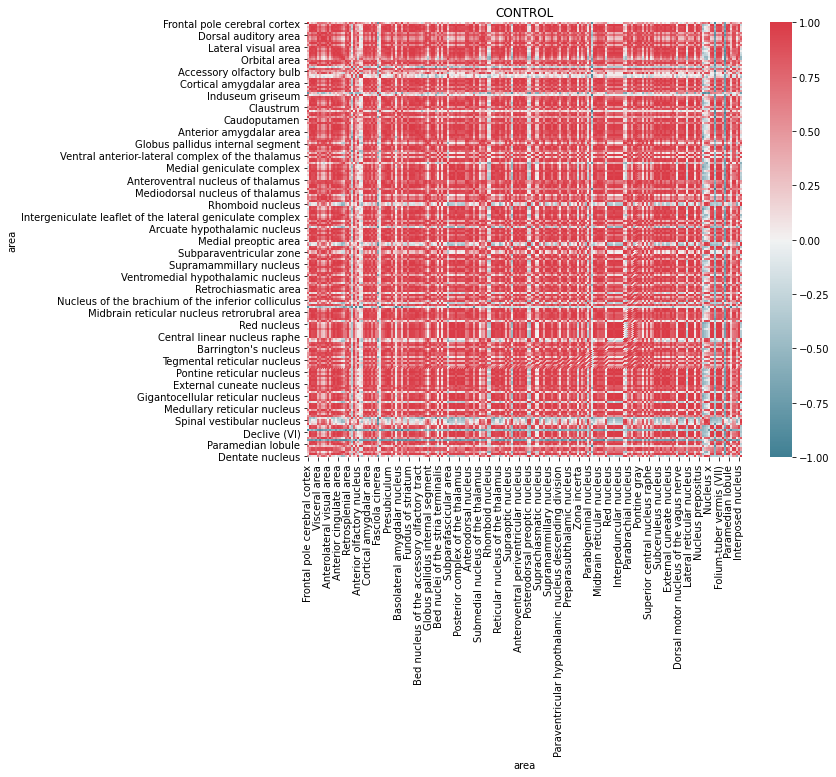

In [63]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

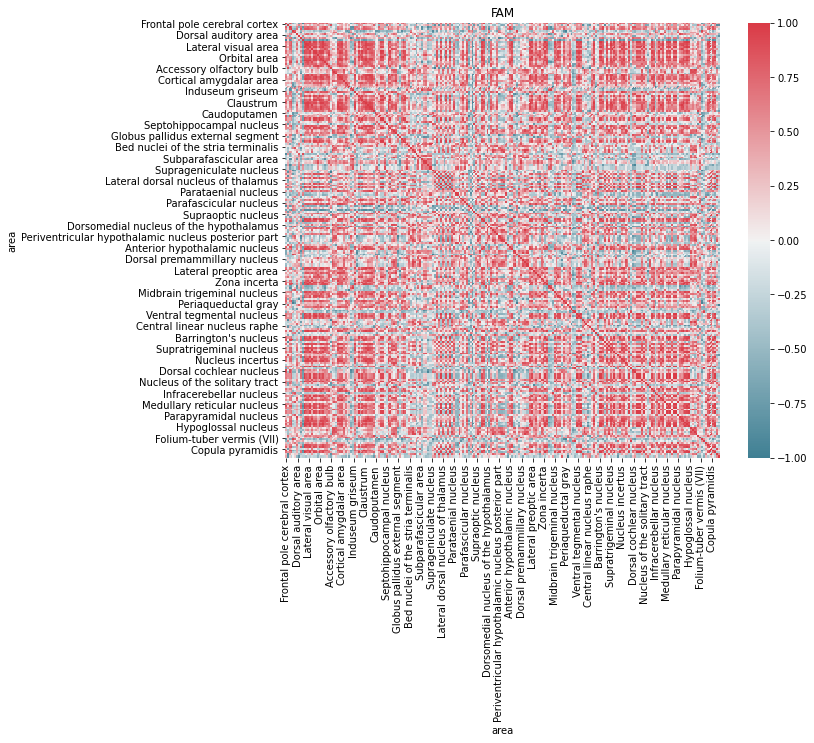

In [64]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

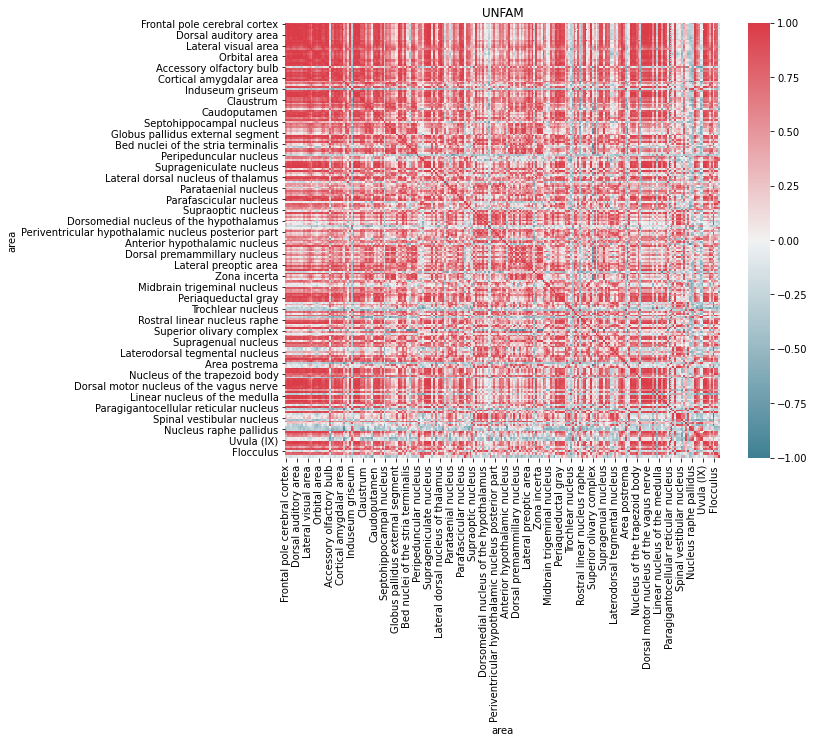

In [65]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')